In [1]:
from elasticsearch import Elasticsearch

client = Elasticsearch(hosts="http://localhost:9200")

In [2]:
import requests

# 计算指南匹配度

text = "碳达峰碳中和目标下乡村绿色低碳发展的保障机制研究"
embeddings: list[list[float]] = requests.post(
    "http://localhost:8002/embedding/text-list",
    json={
        "ls": [text]
    }
).json()

index = "dca9094a-413f-4864-ad99-6d27efb3a12e"
embedding_field = "标题_embedding"  # field type: dense_vector

In [3]:
# 能否使用es根据embedding相似度来查询？

# 获取文本的嵌入向量
embedding = embeddings[0]

# 构建查询
knn = {
    "field": embedding_field,
    "query_vector": embedding,
    "k": 10,
    "num_candidates": 100
}

# 执行查询
response = client.search(index=index, size=10, knn=knn)

# 打印查询结果
for hit in response['hits']['hits']:
    print(
        f"ID: {hit['_id']}, Score: {hit['_score']}, Title: {hit['_source'].get('标题', 'No title available')}"
    )

ID: B12nCY8B0IFD2THs-YQW, Score: 0.96452534, Title: 低碳农业发展模式探析
ID: vVymCY8B0IFD2THsMFzt, Score: 0.96054536, Title: 低碳经济的分层模糊指标评价体系构建与实证研究
ID: JVukCY8B0IFD2THsLhx6, Score: 0.95813304, Title: 我国低碳经济与碳金融研究综述
ID: rVymCY8B0IFD2THsT3N3, Score: 0.9580598, Title: 国有林区低碳经济发展策略研究
ID: lFylCY8B0IFD2THsnwR-, Score: 0.9577204, Title: 推动农村土地流转促进低碳农业的发展--以保护性耕作技术为例
ID: tVulCY8B0IFD2THsIrMW, Score: 0.9577, Title: 农牧复合区低碳型特色农业循环经济模式研究——以河北省张家口市为例
ID: A1ymCY8B0IFD2THsSnDE, Score: 0.9573946, Title: 基于粮食作物碳汇功能的农业生态补偿机制研究
ID: 6FukCY8B0IFD2THs04Op, Score: 0.95676357, Title: 政府补贴下的三级低碳供应链减排博弈研究
ID: 9lylCY8B0IFD2THsvRXV, Score: 0.95653826, Title: 黑龙江省国有林区低碳循环型产业体系构建研究
ID: y1ylCY8B0IFD2THsnwN-, Score: 0.956294, Title: 煤炭开采扰动区农田低碳耕作模式优化模拟研究


In [4]:
test_index = "65e94e64-e526-4298-981b-8168eb142605"
test_title_field = "项目名称"
test_title_embedding = "项目名称_embedding"

# 从 test_index 中随机取 1000 条 test_title_field 和 test_title_embedding
# 存储到 pd.df 中，数据结构：name, embedding

# 对于每条 test 数据，构建 knn 查询 index 的 embedding_field
# 将查询结果的前五条 _score 的值取平均数，添加到 df 的新列 score 中

# 注意，需要筛选 test_index 的 is_embedded = true

In [5]:

import pandas as pd

query = {
    "size": 3000,
    "query": {
        "function_score": {
            "query": {
                "bool": {
                    "must": [
                        # 仅包括 is_embedded 为 true 的记录
                        {"term": {"is_embedded": True}}
                    ]
                }
            },
            "random_score": {}  # 生成随机分数以实现随机排序
        }
    },
    "_source": [test_title_field, test_title_embedding]
}

# 执行查询
response = client.search(index=test_index, body=query)

# 将结果存储到Pandas DataFrame
data = pd.DataFrame([{
    "name": hit["_source"][test_title_field],
    "embedding": hit["_source"][test_title_embedding]
} for hit in response["hits"]["hits"]])

data

,name,embedding
0,Bi4Ti3O12/BiOBr异质结的构建及其光催化性能研究,"[0.033916741609573364, 0.03406115993857384, -0..."
1,仿生鱿鱼—潜航探测器,"[0.003303635399788618, 0.033693864941596985, -..."
2,少儿武道体\n适能课程设\n计的理论构\n架及实践,"[0.028680844232439995, 0.02860274724662304, -0..."
3,单元素二维量子材料的分子束外延生长及其物性研究,"[0.02014082670211792, 0.04285347834229469, -0...."
4,“数字人文”视阈下英语财务报告语篇推销策略对比研究,"[0.0012222902150824666, -0.01281632762402296, ..."
...,...,...
2995,数学建模理论及算法研究,"[0.017354046925902367, 0.024953609332442284, -..."
2996,草莓灰霉病生物防治及产品研发,"[-0.00835449155420065, 0.024927550926804543, -..."
2997,智能访客管理系统设计,"[0.024877356365323067, 0.028930095955729485, -..."
2998,改 I’m hEAR情绪倾诉平台,"[0.01384249422699213, 0.020962029695510864, -0..."


In [7]:
# 初始化得分列
data['score'] = 0.0

for i, row in data.iterrows():
    # 构建k-NN查询
    knn_query = {
        "field": embedding_field,
        "query_vector": row.embedding,
        "k": 30,
        "num_candidates": 100
    }

    # 执行k-NN查询
    knn_response = client.search(index=index, size=5, knn=knn_query)

    # 计算前五个结果的_score平均值
    scores = [hit['_score'] for hit in knn_response['hits']['hits']]
    if scores:
        average_score = sum(scores) / len(scores)
    else:
        average_score = 0  # 如果没有结果，分数为0

    # 更新得分
    data.at[i, 'score'] = average_score

In [8]:
# https://www.elastic.co/cn/what-is/knn
# https://www.elastic.co/guide/en/elasticsearch/reference/master/knn-search.html
# https://www.elastic.co/guide/en/elasticsearch/reference/master/dense-vector.html#dense-vector-similarity

data

,name,embedding,score
0,Bi4Ti3O12/BiOBr异质结的构建及其光催化性能研究,"[0.033916741609573364, 0.03406115993857384, -0...",0.968719
1,仿生鱿鱼—潜航探测器,"[0.003303635399788618, 0.033693864941596985, -...",0.965792
2,少儿武道体\n适能课程设\n计的理论构\n架及实践,"[0.028680844232439995, 0.02860274724662304, -0...",0.960958
3,单元素二维量子材料的分子束外延生长及其物性研究,"[0.02014082670211792, 0.04285347834229469, -0....",0.964732
4,“数字人文”视阈下英语财务报告语篇推销策略对比研究,"[0.0012222902150824666, -0.01281632762402296, ...",0.941411
...,...,...,...
2995,数学建模理论及算法研究,"[0.017354046925902367, 0.024953609332442284, -...",0.967656
2996,草莓灰霉病生物防治及产品研发,"[-0.00835449155420065, 0.024927550926804543, -...",0.969628
2997,智能访客管理系统设计,"[0.024877356365323067, 0.028930095955729485, -...",0.958178
2998,改 I’m hEAR情绪倾诉平台,"[0.01384249422699213, 0.020962029695510864, -0...",0.947152


In [9]:
(data["score"]*100).describe()

count    3000.000000
mean       96.078344
std         0.713756
min        91.741609
25%        95.614188
50%        96.122191
75%        96.574894
max        98.235722
Name: score, dtype: float64

<Axes: xlabel='score_scaled', ylabel='Count'>

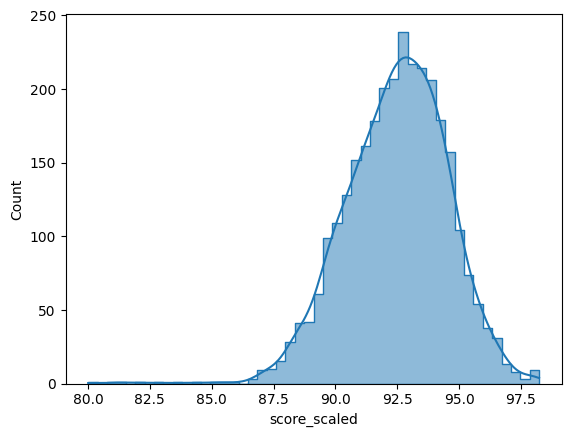

In [10]:
import seaborn as sns


def scale_value(v, A, B, C, D):
    return C + ((D - C) * (v - A) / (B - A))


# 假设data是你的DataFrame，已经有'score'列
# 首先，将score乘以100
data['score_scaled'] = data['score'] * 100

# 然后，应用缩放函数仅对95到98范围内的数据
data['score_scaled'] = data['score_scaled'].apply(
    lambda x: scale_value(x, 90, 98, 75, 98) if 90 <= x <= 98 else x
)

# 这样，所有在95到98范围内

sns.histplot(data=data, x="score_scaled", kde=True, element="step")

<Axes: xlabel='score', ylabel='Count'>

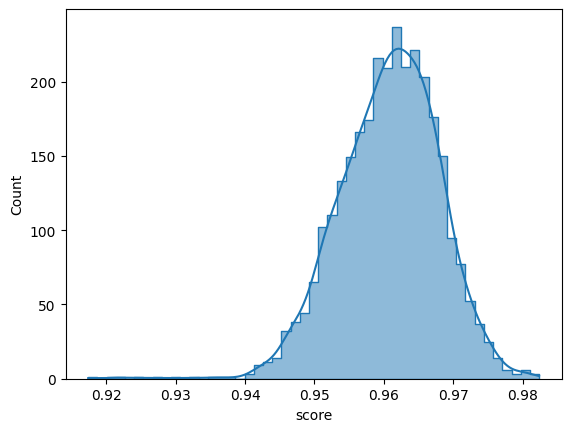

In [11]:
sns.histplot(data=data, x="score", kde=True, element="step")

In [12]:
data['score_scaled'].describe()

count    3000.000000
mean       92.474826
std         2.050876
min        80.007126
25%        91.140791
50%        92.601298
75%        93.902820
max        98.235722
Name: score_scaled, dtype: float64

In [13]:

import pandas as pd

query = {
    "size": 1000,
    "query": {
        "function_score": {
            "query": {
                "bool": {
                    "must": [
                        # 仅包括 is_embedded 为 true 的记录
                        {"term": {"is_embedded": True}}
                    ]
                }
            },
            "random_score": {}  # 生成随机分数以实现随机排序
        }
    },
    "_source": ["标题", "标题_embedding"]
}

# 执行查询
response = client.search(
    index="05ce8f39-4201-48f1-a87a-616c7216470b", body=query)

# 将结果存储到Pandas DataFrame
data_t = pd.DataFrame([{
    "name": hit["_source"]["标题"],
    "embedding": hit["_source"]["标题_embedding"]
} for hit in response["hits"]["hits"]])

data_t

,name,embedding
0,国外药师参与疫苗管理的能力要求及培训体系,"[0.028847768902778625, 0.004568031057715416, -..."
1,习近平的互联网治理思维,"[-0.0022279280237853527, 0.01764770597219467, ..."
2,产业结构演进对东北三省人口流动的影响及对策分析,"[0.008418293669819832, 0.02207220159471035, -0..."
3,基于工业互联网平台的工业机器人系统安全问题研究,"[-0.0013341492740437388, 0.03594762459397316, ..."
4,国企混合所有制改革争议综述,"[0.019967006519436836, 0.033613622188568115, -..."
...,...,...
995,中国传统和谐文化的近代诠释——孙中山关于社会主义和大同社会的思想及其现实意义,"[0.02008374221622944, 0.026328817009925842, -0..."
996,脱贫攻坚与全面建成小康社会的成就与经验研究,"[0.025628317147493362, 0.026998458430171013, -..."
997,论习近平新时代中国特色社会主义思想的社会革命向度,"[0.018026547506451607, 0.01776813715696335, -0..."
998,绿色发展方式与人民对美好生活的向往,"[0.0044745090417563915, 0.0312746986746788, -0..."


In [14]:

def _get_es_knn_scores(text_embedding: list[float], year: int) -> list[float]:
    # 国家级大学生创新创业训练项目
    index = "65e94e64-e526-4298-981b-8168eb142605"
    knn_query = {
        "knn": {
            "field": "项目名称_embedding",
            "query_vector": text_embedding,  # 确保 text_embedding 已经正确生成
            # "k": 30,
            "num_candidates": 100
        }
    }

    filters = {
        "range": {
            "立项时间": {
                "gte": f"{year}-01-01",
                "lte": f"{year}-12-31",
            }
        }
    }

    query = {
        "bool": {
            "must": [
                knn_query
            ],
            "filter": [
                filters
            ]
        }
    }

    knn_response = client.search(
        index=index,
        size=50,
        query=query
    )

    return [hit['_score'] for hit in knn_response['hits']['hits']]


def _get_over_threshold_cnt(scores: list[float], threshold: float):
    return sum(1 for score in scores if score > threshold)


def _get_deltas_avg(series: list[float]):
    this = series[1:]
    last = series[:-1]
    deltas = [vt-vl for vt, vl in zip(this, last)]

    return (sum(deltas) + deltas[-1]) / (len(deltas)+1)


def get_text_trend_for_test(embedding: list[float], th: float):
    knn_s_scores = [
        _get_es_knn_scores(embedding, year)
        for year in (2021, 2022, 2023)
    ]
    cnt_s = [
        _get_over_threshold_cnt(knn_scores, th)
        for knn_scores in knn_s_scores
    ]
    return _get_deltas_avg(cnt_s)


data_t["s93"] = data_t["embedding"].apply(
    lambda x: get_text_trend_for_test(x, 0.93)
)
data_t["s93"].describe()

count    1000.000000
mean        1.888667
std         4.931140
min       -12.333333
25%        -1.333333
50%         1.000000
75%         4.666667
max        21.666667
Name: s93, dtype: float64

In [15]:
data_t["s96"] = data_t["embedding"].apply(
    lambda x: get_text_trend_for_test(x, 0.96)
)
data_t["s96"].describe()

count    1000.000000
mean        0.371333
std         2.138228
min       -11.333333
25%        -0.333333
50%         0.000000
75%         0.666667
max        19.666667
Name: s96, dtype: float64

In [16]:
data_t["s95"] = data_t["embedding"].apply(
    lambda x: get_text_trend_for_test(x, 0.95)
)
data_t["s95"].describe()

count    1000.000000
mean        1.206000
std         4.091057
min       -12.333333
25%        -1.000000
50%         0.333333
75%         3.000000
max        21.333333
Name: s95, dtype: float64

In [17]:
data_t["s94"] = data_t["embedding"].apply(
    lambda x: get_text_trend_for_test(x, 0.94)
)
data_t["s94"].describe()

count    1000.000000
mean        1.820667
std         4.850616
min       -12.333333
25%        -1.333333
50%         1.000000
75%         4.333333
max        21.666667
Name: s94, dtype: float64

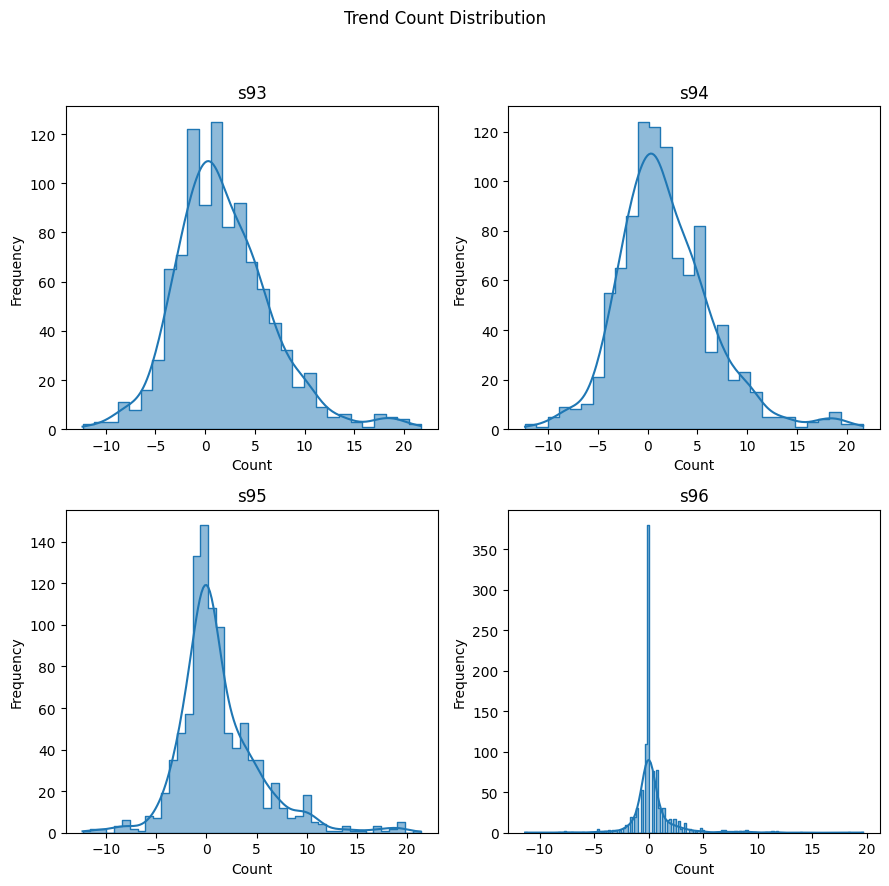

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# 创建一个图像，包含四个子图（每个ac prompt一个子图）
fig, axes = plt.subplots(2, 2, figsize=(9, 9))  # 2x2布局
fig.suptitle('Trend Count Distribution')

# 应用prompt的名称列表
application_prompts = ["s93", "s94", "s95", "s96"]

# 遍历所有学术prompts并绘制每个prompt的分布
for i, prompt_name in enumerate(application_prompts):
    ax = axes[i // 2, i % 2]  # 定位到具体的子图
    sns.histplot(data=data_t, x=prompt_name, kde=True, element="step", ax=ax)
    ax.set_title(prompt_name)
    ax.set_xlabel('Count')
    ax.set_ylabel('Frequency')

plt.tight_layout(rect=[0, 0, 1, 0.95])  # 调整整体布局，避免标题被覆盖
plt.show()
